In [2]:
import numpy as np
from sympy import symbols, Matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pylab as plt

In [3]:
tspan = np.linspace(0, 100, 100)
tshift = 4.79

def sortEig(A):
    l, v = la.eig(A)
    idx = np.argsort(np.real(l))
    l_sorted = l[idx]
    v_sorted = v[:, idx]
    return l_sorted, v_sorted

def ode_system_nonlinear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P, P_apc, P_kras = y
    sum_n345 = n3 + n4 + n5
    CC_A = 1 - sum_n345 / KA
    CC_R = 1 - sum_n345 / KR
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3*CC_A - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4*CC_R - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5*CC_R - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    dP_apcdt = R36 * n3 * (1-P_apc)
    dP_krasdt = R56 * n3 * (1-P_kras)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt, dP_apcdt, dP_krasdt]

def ode_system_linear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3 - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4 - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5 - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

In [4]:
# Our Best
r1 = 156
u = 10e-7 * r1
mu = 10e-9 * r1
values = {
    "N_crypts": 1e+7,
    "r1": r1,
    "u": u,
    "mu": mu,
    "gamma3": 0.2,
    "gamma4": 0.07,
    "gamma5": 0.07,
    "delta": 0.05,
    "KA": 562,
    "KR": 1780,
    "R12": 2 * u,
    "R14": mu,
    "R23": u,
    "R25": mu,
    "R36": mu,
    "R45": 2 * u,
    "R56": u,
}
globals().update(values)

In [6]:
# Import the clinical data and plot

# Data for Gm and Gf
Gm = [
    [57, 16.8, 6.7, 0.6],
    [62, 18.1, 8.3, 1.0],
    [67, 19.2, 9.3, 1.3],
    [72, 19.9, 10.1, 2.0],
    [77, 19.1, 10.5, 2.6],
    [58, 17.9, 7.1, 0.7],
    [63, 19.1, 8.7, 1.1],
    [68, 20.1, 9.7, 1.5],
    [73, 20.6, 10.3, 2.1],
    [78, 19.6, 10.6, 2.7]
]

Gf = [
    [57, 10.1, 3.6, 0.3],
    [62, 11.4, 4.6, 0.5],
    [67, 12.6, 5.4, 0.7],
    [72, 13.7, 6.2, 1.1],
    [77, 13.5, 6.8, 1.6],
    [58, 10.9, 3.9, 0.4],
    [63, 12.2, 4.9, 0.5],
    [68, 13.4, 5.6, 0.8],
    [73, 14.3, 6.4, 1.2],
    [78, 13.9, 7.0, 1.7]
]

# Calculate incidence per age
Gm_data = [[row[0], (row[2] + row[3]) / 100] for row in Gm]
Gf_data = [[row[0], (row[2] + row[3]) / 100] for row in Gf]

# Sort both data sets
Gm_data_sort = sorted(Gm_data, key=lambda x: x[0])
GF_data_sort = sorted(Gf_data, key=lambda x: x[0])

# Average and sort
data = [[x[0], (x[1] + y[1]) / 2] for x, y in zip(Gm_data_sort, GF_data_sort)]
data_sorted = sorted(data, key=lambda x: x[0])

# Extract x and y values for plotting
x_dat = [row[0] for row in data_sorted]
y_dat = [row[1] for row in data_sorted]
#plt.scatter(x_dat,y_dat)

Best Parameter Sets:
1. SSE: 0.0000, R: 156.00, KA: 5.62e+02, KR: 1.78e+03
2. SSE: 0.0001, R: 168.00, KA: 1.78e+01, KR: 1.33e+03
3. SSE: 0.0001, R: 168.00, KA: 1.33e+01, KR: 1.33e+03
4. SSE: 0.0001, R: 168.00, KA: 1.00e+01, KR: 1.33e+03
5. SSE: 0.0001, R: 168.00, KA: 2.37e+01, KR: 1.33e+03
6. SSE: 0.0001, R: 168.00, KA: 3.16e+01, KR: 1.33e+03
7. SSE: 0.0001, R: 168.00, KA: 4.22e+01, KR: 1.33e+03
8. SSE: 0.0001, R: 168.00, KA: 5.62e+01, KR: 1.33e+03
9. SSE: 0.0001, R: 168.00, KA: 7.50e+01, KR: 1.33e+03
10. SSE: 0.0001, R: 174.00, KA: 4.22e+02, KR: 1.00e+03
11. SSE: 0.0001, R: 186.00, KA: 1.78e+02, KR: 7.50e+02
12. SSE: 0.0001, R: 168.00, KA: 1.00e+02, KR: 1.33e+03
13. SSE: 0.0001, R: 186.00, KA: 2.37e+02, KR: 7.50e+02
14. SSE: 0.0001, R: 174.00, KA: 3.16e+02, KR: 1.00e+03
15. SSE: 0.0001, R: 186.00, KA: 1.33e+02, KR: 7.50e+02
16. SSE: 0.0001, R: 168.00, KA: 1.33e+02, KR: 1.33e+03
17. SSE: 0.0001, R: 150.00, KA: 1.00e+03, KR: 1.78e+03
18. SSE: 0.0001, R: 156.00, KA: 4.22e+02, KR: 1.78e+0

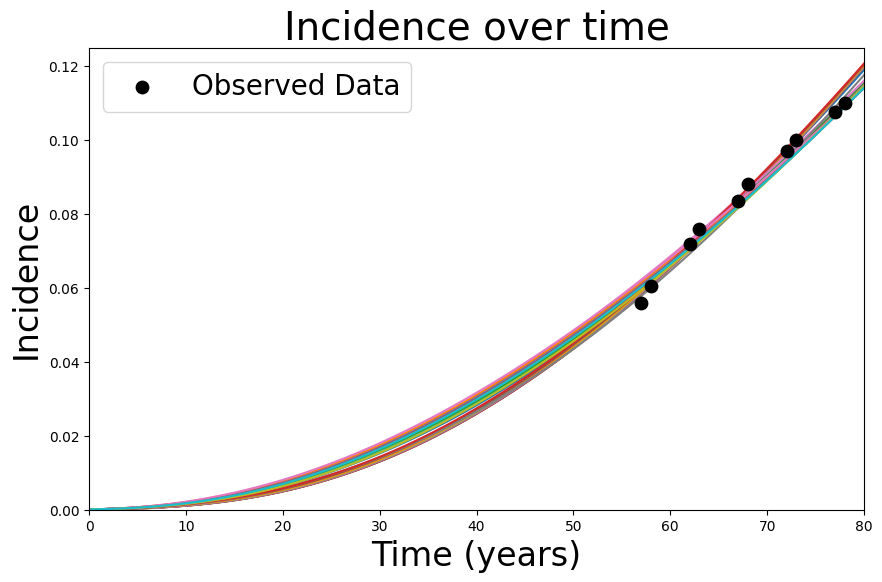

In [ ]:
# Iterate over a range of parameters to find the best fit, Fig 2c
# Initial Parameters
N_crypts = 1e+7
rmin = 150
rmax = 270
rsteps = 20
r_array = np.linspace(rmin, rmax, rsteps + 1)

gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
kmin = 1
kmax = 3.5
ksteps = 20
ka_array = np.logspace(kmin, kmax, ksteps + 1) 
kr_array = np.logspace(kmin, kmax, ksteps + 1)  

# Error tracking
errors = []

# Iterate through parameters
for r_1 in r_array:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1

    for ka in ka_array:
        for kr in kr_array:
            # Solve ODE system
            sol = solve_ivp(
                ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0,0,0], 
                t_eval=tspan, method="RK45", 
                args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
            )
            # Adjust x_dat to match the time step (shift by 4.79)
            t_search = np.array(x_dat) + 4.79
            
            # Match data to model
            model_values = np.interp(t_search, sol.t, sol.y[5, :]) * (1 - delta / 1.01199)
            
            # Calculate SSE
            sse = np.sum((model_values - y_dat)**2)
            
            # Store parameters and error
            errors.append((sse, r_1, ka, kr))

# Sort errors by SSE
errors = sorted(errors, key=lambda x: x[0])

# Get the best parameter sets
best_params = errors[:30]

print("Best Parameter Sets:")
for rank, (sse, r_1, ka, kr) in enumerate(best_params, start=1):
    print(f"{rank}. SSE: {sse:.4f}, R: {r_1:.2f}, KA: {ka:.2e}, KR: {kr:.2e}")

# Plot the best models
plt.figure(figsize=(10, 6))
for _, r_1, ka, kr in best_params:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1
    
    sol = solve_ivp(
        ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0,0,0], 
        t_eval=tspan, method="RK45", 
        args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
    )

    # Get model values for plotting
    model_values = sol.y[5, :] * (1 - delta / 1.01199)
    plt.plot(sol.t - 4.79, model_values, zorder=1) #label=f"R={r_1:.2f}, KA={ka:.2e}, KR={kr:.2e}")

# Plot observed data
plt.scatter(x_dat, y_dat, color='black', s=80, zorder=2, label="Observed Data")

# Add labels, legend, and title
plt.xlabel('Time (years)',fontsize =24)
plt.ylabel('Incidence', fontsize = 24)
plt.xlim(0, 80)
plt.ylim(0,0.125)
plt.title("Incidence over time",fontsize = 28)
plt.legend(loc='upper left', fontsize = 20)
plt.show()


Best Parameter Sets:
1. SSE: 0.0001, R: 186.00, KA: 1.78e+02, KR: 7.50e+02
2. SSE: 0.0001, R: 186.00, KA: 2.37e+02, KR: 7.50e+02
3. SSE: 0.0001, R: 186.00, KA: 1.33e+02, KR: 7.50e+02
4. SSE: 0.0001, R: 186.00, KA: 1.00e+02, KR: 7.50e+02
5. SSE: 0.0001, R: 186.00, KA: 7.50e+01, KR: 7.50e+02
6. SSE: 0.0001, R: 186.00, KA: 5.62e+01, KR: 7.50e+02
7. SSE: 0.0001, R: 186.00, KA: 3.16e+02, KR: 7.50e+02
8. SSE: 0.0001, R: 186.00, KA: 4.22e+01, KR: 7.50e+02
9. SSE: 0.0001, R: 186.00, KA: 3.16e+01, KR: 7.50e+02
10. SSE: 0.0001, R: 186.00, KA: 2.37e+01, KR: 7.50e+02
11. SSE: 0.0001, R: 186.00, KA: 1.78e+01, KR: 7.50e+02
12. SSE: 0.0001, R: 186.00, KA: 1.33e+01, KR: 7.50e+02
13. SSE: 0.0001, R: 186.00, KA: 1.00e+01, KR: 7.50e+02
14. SSE: 0.0001, R: 180.00, KA: 5.62e+02, KR: 7.50e+02
15. SSE: 0.0001, R: 186.00, KA: 4.22e+02, KR: 7.50e+02
16. SSE: 0.0002, R: 168.00, KA: 1.00e+03, KR: 7.50e+02
17. SSE: 0.0002, R: 156.00, KA: 1.33e+03, KR: 7.50e+02
18. SSE: 0.0002, R: 174.00, KA: 7.50e+02, KR: 7.50e+0

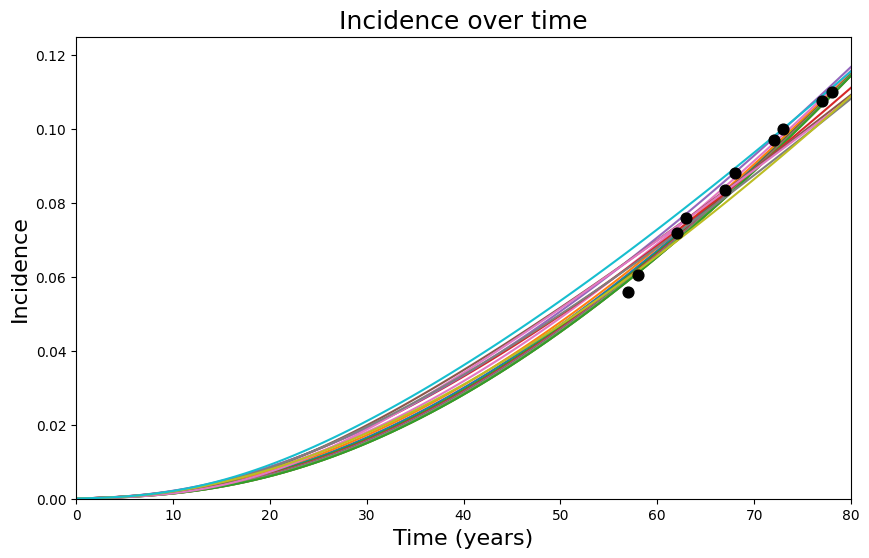

In [ ]:
# Alleged Paper procedure
# Initial Parameters
N_crypts = 1e+7
rmin = 150
rmax = 270
rsteps = 20
r_array = np.linspace(rmin, rmax, rsteps + 1)  # R values

gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
kmin = 1
kmax = 3.5
ksteps = 20
ka_array = np.logspace(kmin, kmax, ksteps + 1)  # KA values (logarithmic scale)
kr_array = np.logspace(kmin, kmax, ksteps + 1)  # KR values (logarithmic scale)

# Error tracking
errors = []

# Iterate through parameters
for r_1 in r_array:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1

    for ka in ka_array:
        # Solve ODE system
        sol = solve_ivp(
            ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0,0,0], 
            t_eval=tspan, method="RK45", 
            args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
        )
        # Adjust x_dat to match the time step (shift by 4.79)
        t_search = np.array(x_dat) + 4.79
        
        # Match data to model
        model_values = np.interp(t_search, sol.t, sol.y[5, :]) * (1 - delta / 1.01199)
        
        # Calculate SSE
        sse = np.sum((model_values - y_dat)**2)
        
        # Store parameters and error
        errors.append((sse, r_1, ka, kr))

# Sort errors by SSE
errors = sorted(errors, key=lambda x: x[0])

# Get the best parameter sets
best_params = errors[:20]

print("Best Parameter Sets:")
for rank, (sse, r_1, ka, kr) in enumerate(best_params, start=1):
    print(f"{rank}. SSE: {sse:.4f}, R: {r_1:.2f}, KA: {ka:.2e}, KR: {kr:.2e}")

# Plot the best models
plt.figure(figsize=(10, 6))
for _, r_1, ka, kr in best_params:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1
    
    sol = solve_ivp(
        ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0,0,0], 
        t_eval=tspan, method="RK45", 
        args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
    )

    # Get model values for plotting
    model_values = sol.y[5, :] * (1 - delta / 1.01199)
    plt.plot(sol.t - 4.79, model_values, zorder=1) #label=f"R={r_1:.2f}, KA={ka:.2e}, KR={kr:.2e}")

# Plot observed data
plt.scatter(x_dat, y_dat, color='black', s=60, zorder=2, label="Observed Data")

# Add labels, legend, and title
plt.xlabel('Time (years)',fontsize = 16)
plt.ylabel('Incidence', fontsize = 16)
plt.xlim(0, 80)
plt.ylim(0,0.125)
plt.title("Incidence over time",fontsize = 18)
#plt.legend(loc='upper left')
plt.show()

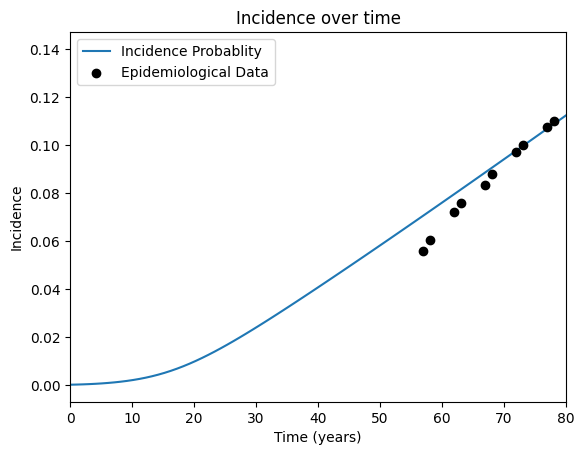

In [ ]:
# Paper best parameter values, appendix graph
r_1 = 204
u = 10e-7 * r_1
mu = 10e-9 * r_1
KA = 1000
KR = 17
N_crypts = 1e7
sol = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0,0,0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))


plt.plot(sol.t-4.97, sol.y[5,:]*(1-delta/1.01199), zorder=1, label='Incidence Probablity')
plt.scatter(x_dat,y_dat,color='k', zorder=2, label='Epidemiological Data')
plt.xlim(0,80)
plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.legend(loc='upper left')
plt.title("Incidence over time")
#plt.savefig('figures/SimulationIncidenceProbabililty.png')
plt.show()

In [8]:
# Linearization
from sympy import symbols, Matrix

# Define the symbols with "_symbol" suffix
R12_symbol, R14_symbol, R23_symbol, R25_symbol, R36_symbol, R45_symbol, R56_symbol = symbols('R12_symbol R14_symbol R23_symbol R25_symbol R36_symbol R45_symbol R56_symbol')
K_A_symbol, K_R_symbol, gamma3_symbol, gamma4_symbol, gamma5_symbol, delta_symbol = symbols('K_A_symbol K_R_symbol gamma3_symbol gamma4_symbol gamma5_symbol delta_symbol')
n3_symbol, n4_symbol, n5_symbol, P_symbol = symbols('n3_symbol n4_symbol n5_symbol P_symbol')

# Define A, B, and C with the updated symbols
A = -R36_symbol + gamma3_symbol - (2 * gamma3_symbol * n3_symbol) / K_A_symbol - (gamma3_symbol * n4_symbol) / K_A_symbol - (gamma3_symbol * n5_symbol) / K_A_symbol - delta_symbol
B = -R45_symbol + gamma4_symbol - (gamma4_symbol * n3_symbol) / K_R_symbol - (2 * gamma4_symbol * n4_symbol) / K_R_symbol - (gamma4_symbol * n5_symbol) / K_R_symbol - delta_symbol
C = -R56_symbol + gamma5_symbol - (gamma5_symbol * n3_symbol) / K_R_symbol - (gamma5_symbol * n4_symbol) / K_R_symbol - (2 * gamma5_symbol * n5_symbol) / K_R_symbol - delta_symbol

# Define the matrix J with updated symbols
J = Matrix([
    [-R12_symbol - R14_symbol, 0, 0, 0, 0, 0],
    [R12_symbol, -R23_symbol - R25_symbol, 0, 0, 0, 0],
    [0, R23_symbol, A, -gamma3_symbol * n3_symbol / K_A_symbol, -gamma3_symbol * n3_symbol / K_A_symbol, 0],
    [R14_symbol, 0, -gamma4_symbol * n4_symbol / K_R_symbol, B, -gamma4_symbol * n4_symbol / K_R_symbol, 0],
    [0, R25_symbol, -gamma5_symbol * n5_symbol / K_R_symbol, R45_symbol - gamma5_symbol * n5_symbol / K_R_symbol, C, 0],
    [0, 0, R36_symbol - R36_symbol * P_symbol, 0, R56_symbol - R56_symbol * P_symbol, -R56_symbol * n5_symbol - R36_symbol * n3_symbol]
])

# Substitute n3, n4, n5, and P = 0 into the matrix (1st equilibrium points)
J_equilibrium = J.subs({n3_symbol: 0, n4_symbol: 0, n5_symbol: 0, P_symbol: 0})

# Display the resulting matrix
print("Matrix J at equilibrium points:")
print(J_equilibrium)
J_result = np.array(J_equilibrium.subs({
    R12_symbol: values["R12"],
    R14_symbol: values["R14"],
    R23_symbol: values["R23"],
    R25_symbol: values["R25"],
    R36_symbol: values["R36"],
    R45_symbol: values["R45"],
    R56_symbol: values["R56"],
    K_A_symbol: values["KA"],
    K_R_symbol: values["KR"],
    gamma3_symbol: values["gamma3"],
    gamma4_symbol: values["gamma4"],
    gamma5_symbol: values["gamma5"],
    delta_symbol: values["delta"],
}).tolist(), dtype=float)

print("Matrix J Result in:")
print(J_result)

Matrix J at equilibrium points:
Matrix([[-R12_symbol - R14_symbol, 0, 0, 0, 0, 0], [R12_symbol, -R23_symbol - R25_symbol, 0, 0, 0, 0], [0, R23_symbol, -R36_symbol - delta_symbol + gamma3_symbol, 0, 0, 0], [R14_symbol, 0, 0, -R45_symbol - delta_symbol + gamma4_symbol, 0, 0], [0, R25_symbol, 0, R45_symbol, -R56_symbol - delta_symbol + gamma5_symbol, 0], [0, 0, R36_symbol, 0, R56_symbol, 0]])
Matrix J Result in:
[[-3.1356000e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.1200000e-04 -1.5756000e-04  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.5600000e-04  1.4999844e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.5600000e-06  0.0000000e+00  0.0000000e+00  1.9688000e-02
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.5600000e-06  0.0000000e+00  3.1200000e-04
   1.9844000e-02  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.5600000e-06  0.0000000e+00
   1.5600000e-04  0.0000000e+00]]
